# <center> QCNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
from jax.config import config

config.update("jax_enable_x64", True)
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## Get Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[..., np.newaxis] / 255.0


def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = y == a
    return x, y


x_train, y_train = filter_pair(x_train, y_train, 1, 5)  # classify 1, 5 only
x_train_small = tf.image.resize(x_train, (4, 4)).numpy()
x_train_bin = np.array(x_train_small > 0.5, dtype=np.float32)  # binary input
x_train_bin = np.squeeze(x_train_bin)[:10000]

# tensorflow data
x_train_tf = tf.reshape(tf.constant(x_train_bin, dtype=tf.float64), [-1, 16]) 
y_train_tf = tf.constant(y_train[:10000], dtype=tf.float64)

## QCNN net

In [11]:
def QCNN(x, weights):
    n = 16
    x = tc.backend.cast(x, "complex128")
    weights = tc.backend.cast(weights, "complex128")
    c = tc.Circuit(n)
    
    for i in range(n):
        c.rx(i, theta=tf.acos(x[i]))

    # convolution layer 1
    for i in range(n-1):
        c.exp1(i, i+1, theta=weights[i, 0], unitary=tc.gates._xx_matrix)
        c.exp1(i, i+1, theta=weights[i, 1], unitary=tc.gates._zz_matrix)
    for i in range(1, n-3, 3):
        c.exp1(i, i+3, theta=weights[i, 2], unitary=tc.gates._zz_matrix)
    for i in range(0, n-2, 3):
        c.toffoli(i, i+2, i+1)

    # pooling layer 1
    for i in range(0, n-2, 3):
        c.h(i+2)
        c.multicontrol(i+2, i+1, ctrl=[1], unitary=tc.gates.z())
        c.h(i)
        c.multicontrol(i, i+1, ctrl=[1], unitary=tc.gates.z())
    # after c-p layers, only i%3==1 remain

    # convolution layer 2
    for i in range(1, n-4, 3):
        c.exp1(i, i+3, theta=weights[i, 3], unitary=tc.gates._xx_matrix)
        c.exp1(i, i+3, theta=weights[i, 4], unitary=tc.gates._zz_matrix)
    for i in range(4, n-10, 9):
        c.exp1(i, i+9, theta=weights[i, 5], unitary=tc.gates._zz_matrix)
    for i in range(1, n-7, 9):
        c.toffoli(i, i+6, i+3)

    # pooling layer 2
    for i in range(1, n-7, 9):
        c.ry(i+6, theta=-0.5)
        c.multicontrol(i+6, i+3, ctrl=[1], unitary=tc.gates.z())   
        c.ry(i, theta=-0.5)
        c.multicontrol(i, i+3, ctrl=[1], unitary=tc.gates.z())
    # after c-p layers, only i%9==4 remain

    # measure
    ypreds = []
    for i in range(4, n-4, 9):
        ypred = c.expectation([tc.gates.x(), (i,)])
        ypred = tc.backend.real(ypred)
        ypred = (tc.backend.real(ypred) + 1) / 2.0
        ypreds.append(ypred)
    return tc.backend.stack(ypreds)

## train

In [20]:
ql = tc.keras.QuantumLayer(QCNN, [(16, 6)])  # func, weights_shape  initializer='glorot_normal'
model = tf.keras.Sequential([
    ql, 
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu")
    ])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

history = model.fit(x_train_tf, y_train_tf, batch_size=100, epochs=50, shuffle=True)

Epoch 1/50
100/100 [==============================] - 105s 804ms/step - loss: 0.6142 - binary_accuracy: 0.6733
Epoch 2/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4591 - binary_accuracy: 0.8359
Epoch 3/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4226 - binary_accuracy: 0.8550
Epoch 4/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4150 - binary_accuracy: 0.8539
Epoch 5/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4086 - binary_accuracy: 0.8539
Epoch 6/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4122 - binary_accuracy: 0.8536
Epoch 7/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4014 - binary_accuracy: 0.8536
Epoch 8/50
100/100 [==============================] - 80s 804ms/step - loss: 0.4030 - binary_accuracy: 0.8574
Epoch 9/50
100/100 [==============================] - 80s 804ms/step - loss: 0.3986 - binary_accuracy: 0.8567
Epoch 10/

## plot

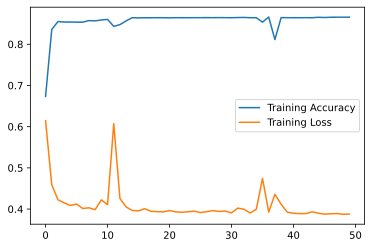

In [21]:
acc = history.history['binary_accuracy']
loss = history.history['loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(loss, label='Training Loss')
plt.legend()
plt.show()